In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
!pip install rockpool

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 593.0/593.0 kB 9.3 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for rockpool: filename=rockpool-2.9.2.1-py3-none-any.whl size=719771 sha256=933a93e38e21016ad6940b66bfa5f9940c763a51f88301ece1112e33581aeea4
  Stored in directory: /root/.cache/pip/wheels/65/56/df/edce2d80279a39267d6fd58c183545c958ca1e6c35e4392d42
Successfully built rockpool


In [ ]:
! pip install "rockpool[all]"

  Preparing metadata (setup.py) ... done
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
  Using cached pybind11-2.13.6-py3-none-any.whl.metadata (9.5 kB)
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 46.1/46.1 kB 4.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 99.8/99.8 kB 10.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 3.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 118.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 94.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 54.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 1.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 11.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 36.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━

In [3]:
import torch
import numpy as np
import torch.nn.functional as F
from torch.utils.data import TensorDataset, DataLoader
from rockpool.nn.networks import SynNet
from torch.optim import Adam
from tqdm import tqdm

# ==== 1. 配置硬件 ====
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

# ==== 2. 加载数据 ====
X_train = torch.from_numpy(np.load("/content/drive/My Drive/SD-project/X_train.npy")).float()
y_train = torch.from_numpy(np.load("/content/drive/My Drive/SD-project/y_train.npy")).long()
X_val = torch.from_numpy(np.load("/content/drive/My Drive/SD-project/X_val.npy")).float()
y_val = torch.from_numpy(np.load("/content/drive/My Drive/SD-project/y_val.npy")).long()




/usr/local/lib/python3.11/dist-packages/rockpool/nn/networks/__init__.py:15: UserWarning: This module needs to be ported to the v2 API.
  warnings.warn(f"{err}")
/usr/local/lib/python3.11/dist-packages/rockpool/nn/networks/__init__.py:20: UserWarning: This module needs to be ported to the v2 API.
  warnings.warn(f"{err}")


Using device: cuda:0


In [5]:
train_ds = TensorDataset(X_train, y_train)
val_ds = TensorDataset(X_val, y_val)


train_dl = DataLoader(train_ds, batch_size=512, shuffle=True, drop_last=True, pin_memory=True, num_workers=6)
val_dl = DataLoader(val_ds, batch_size=512, shuffle=False, drop_last=False, pin_memory=True, num_workers=6)



In [6]:
# ==== 3. 构建模型 ====
n_channels = 16
n_classes = 3

net = SynNet(
    output="vmem",
    p_dropout=0,
    n_channels=n_channels,
    n_classes=n_classes,
    size_hidden_layers=[24, 24, 24],
    time_constants_per_layer=[2, 4, 8],
).to(device)

optimizer = Adam(net.parameters().astorch(), lr=1e-3)

# ==== 4. 定义损失函数 ====
def one_hot_mse_loss(outputs, labels, num_classes):
    target_onehot = F.one_hot(labels, num_classes=num_classes).float().to(outputs.device)
    return F.mse_loss(outputs, target_onehot)

# ==== 5. 开始训练 ====
n_epochs = 100
best_val_acc = 0.0
best_state = None
train_acc_list = []
train_loss_list = []
val_acc_list = []
skip_window = 30
for epoch in range(n_epochs):
    net.train()
    correct = 0
    total = 0
    total_loss = 0

    for xb, yb in tqdm(train_dl, desc=f"Epoch {epoch}"):
        xb, yb = xb.to(device), yb.to(device)
        optimizer.zero_grad()

        out, _, _ = net(xb)
        sum_out = torch.cumsum(out[:,skip_window:,:], dim=1)[:, -1, :]  # time axis = 1
        loss = one_hot_mse_loss(sum_out, yb, num_classes=n_classes)

        loss.backward()
        optimizer.step()

        total_loss += loss.item() * xb.size(0)
        pred = torch.argmax(sum_out, dim=1)
        correct += (pred == yb.to(pred.device)).sum().item()
        total += yb.size(0)

    avg_loss = total_loss / total
    acc = 100 * correct / total
    train_acc_list.append(acc)
    train_loss_list.append(avg_loss)
    print(f"Epoch {epoch}: Train Loss={avg_loss:.4f}, Accuracy={acc:.2f}%")

    # ==== 验证 ====
    net.eval()
    correct = 0
    total = 0

    with torch.no_grad():
        for xb, yb in val_dl:
            xb, yb = xb.to(device), yb.to(device)
            out, _, _ = net(xb)
            sum_out = torch.cumsum(out[:,skip_window:,:], dim=1)[:, -1, :]
            pred = torch.argmax(sum_out, dim=1)
            correct += (pred == yb.to(pred.device)).sum().sum().item()
            total += yb.size(0)

    val_acc = 100 * correct / total
    val_acc_list.append(val_acc)

    print(f"  [Val] Accuracy: {val_acc:.2f}%")

    if val_acc > best_val_acc:
        best_val_acc = val_acc
        best_state = net.state_dict()
        torch.save(best_state, "/content/drive/My Drive/SD-project/best_snn_model.pth")
        print(f"  ✅ New best model saved at epoch {epoch} with val acc {val_acc:.2f}%")

print(f"\n🎯 Best Validation Accuracy: {best_val_acc:.2f}%")

Epoch 0: 100%|██████████| 205/205 [02:59<00:00,  1.14it/s]

Epoch 0: Train Loss=0.7363, Accuracy=33.52%


  [Val] Accuracy: 33.56%
  ✅ New best model saved at epoch 0 with val acc 33.56%


Epoch 1: 100%|██████████| 205/205 [02:58<00:00,  1.15it/s]

Epoch 1: Train Loss=0.5153, Accuracy=33.89%


  [Val] Accuracy: 33.95%
  ✅ New best model saved at epoch 1 with val acc 33.95%


Epoch 2: 100%|██████████| 205/205 [02:58<00:00,  1.15it/s]

Epoch 2: Train Loss=0.6200, Accuracy=34.18%


  [Val] Accuracy: 34.44%
  ✅ New best model saved at epoch 2 with val acc 34.44%


Epoch 3: 100%|██████████| 205/205 [02:58<00:00,  1.15it/s]

Epoch 3: Train Loss=0.6308, Accuracy=34.09%


  [Val] Accuracy: 36.16%
  ✅ New best model saved at epoch 3 with val acc 36.16%


Epoch 4: 100%|██████████| 205/205 [02:59<00:00,  1.15it/s]

Epoch 4: Train Loss=0.8701, Accuracy=34.54%


  [Val] Accuracy: 36.02%


Epoch 5: 100%|██████████| 205/205 [02:59<00:00,  1.14it/s]

Epoch 5: Train Loss=0.7167, Accuracy=34.30%


  [Val] Accuracy: 36.00%


Epoch 6: 100%|██████████| 205/205 [03:01<00:00,  1.13it/s]

Epoch 6: Train Loss=0.5965, Accuracy=35.22%


  [Val] Accuracy: 34.27%


Epoch 7: 100%|██████████| 205/205 [03:00<00:00,  1.14it/s]

Epoch 7: Train Loss=0.8169, Accuracy=34.71%


  [Val] Accuracy: 34.45%


Epoch 8: 100%|██████████| 205/205 [02:59<00:00,  1.14it/s]

Epoch 8: Train Loss=0.6078, Accuracy=36.32%


  [Val] Accuracy: 38.20%
  ✅ New best model saved at epoch 8 with val acc 38.20%


Epoch 9: 100%|██████████| 205/205 [02:59<00:00,  1.14it/s]

Epoch 9: Train Loss=0.4963, Accuracy=36.54%


  [Val] Accuracy: 38.14%


Epoch 10: 100%|██████████| 205/205 [02:59<00:00,  1.14it/s]

Epoch 10: Train Loss=0.4984, Accuracy=38.67%


  [Val] Accuracy: 41.10%
  ✅ New best model saved at epoch 10 with val acc 41.10%


Epoch 11: 100%|██████████| 205/205 [03:00<00:00,  1.14it/s]

Epoch 11: Train Loss=0.4274, Accuracy=38.82%


  [Val] Accuracy: 39.04%


Epoch 12: 100%|██████████| 205/205 [02:59<00:00,  1.14it/s]

Epoch 12: Train Loss=0.4274, Accuracy=39.40%


  [Val] Accuracy: 39.50%


Epoch 13: 100%|██████████| 205/205 [03:00<00:00,  1.14it/s]

Epoch 13: Train Loss=0.4931, Accuracy=37.64%


  [Val] Accuracy: 38.86%


Epoch 14: 100%|██████████| 205/205 [03:00<00:00,  1.14it/s]

Epoch 14: Train Loss=0.3891, Accuracy=39.47%


  [Val] Accuracy: 39.36%


Epoch 15: 100%|██████████| 205/205 [02:59<00:00,  1.14it/s]

Epoch 15: Train Loss=0.3814, Accuracy=37.34%


  [Val] Accuracy: 36.10%


Epoch 16: 100%|██████████| 205/205 [03:00<00:00,  1.14it/s]

Epoch 16: Train Loss=0.3973, Accuracy=35.61%


  [Val] Accuracy: 35.10%


Epoch 17: 100%|██████████| 205/205 [02:59<00:00,  1.14it/s]

Epoch 17: Train Loss=0.3766, Accuracy=35.08%


  [Val] Accuracy: 33.83%


Epoch 18: 100%|██████████| 205/205 [02:59<00:00,  1.14it/s]

Epoch 18: Train Loss=0.3773, Accuracy=36.56%


  [Val] Accuracy: 38.71%


Epoch 19: 100%|██████████| 205/205 [02:58<00:00,  1.15it/s]

Epoch 19: Train Loss=0.3576, Accuracy=36.33%


  [Val] Accuracy: 38.34%


Epoch 20: 100%|██████████| 205/205 [02:59<00:00,  1.14it/s]

Epoch 20: Train Loss=0.3326, Accuracy=37.40%


  [Val] Accuracy: 38.51%


Epoch 21: 100%|██████████| 205/205 [02:58<00:00,  1.15it/s]

Epoch 21: Train Loss=0.3484, Accuracy=37.05%


  [Val] Accuracy: 39.27%


Epoch 22: 100%|██████████| 205/205 [02:58<00:00,  1.15it/s]

Epoch 22: Train Loss=0.3776, Accuracy=37.38%


  [Val] Accuracy: 38.83%


Epoch 23: 100%|██████████| 205/205 [02:58<00:00,  1.15it/s]

Epoch 23: Train Loss=0.3560, Accuracy=36.66%


  [Val] Accuracy: 34.20%


Epoch 24: 100%|██████████| 205/205 [03:00<00:00,  1.14it/s]

Epoch 24: Train Loss=0.3456, Accuracy=36.99%


  [Val] Accuracy: 37.81%


Epoch 25: 100%|██████████| 205/205 [02:58<00:00,  1.15it/s]

Epoch 25: Train Loss=0.3431, Accuracy=35.95%


  [Val] Accuracy: 38.22%


Epoch 26: 100%|██████████| 205/205 [02:58<00:00,  1.15it/s]

Epoch 26: Train Loss=0.3299, Accuracy=37.04%


  [Val] Accuracy: 38.88%


Epoch 27: 100%|██████████| 205/205 [02:59<00:00,  1.14it/s]

Epoch 27: Train Loss=0.3247, Accuracy=38.66%


  [Val] Accuracy: 39.86%


Epoch 28: 100%|██████████| 205/205 [02:59<00:00,  1.14it/s]

Epoch 28: Train Loss=0.3350, Accuracy=38.51%


  [Val] Accuracy: 36.50%


Epoch 29: 100%|██████████| 205/205 [02:58<00:00,  1.15it/s]

Epoch 29: Train Loss=0.3441, Accuracy=38.09%


  [Val] Accuracy: 38.69%


Epoch 30: 100%|██████████| 205/205 [02:58<00:00,  1.15it/s]

Epoch 30: Train Loss=0.3239, Accuracy=38.93%


  [Val] Accuracy: 40.22%


Epoch 31: 100%|██████████| 205/205 [02:59<00:00,  1.14it/s]

Epoch 31: Train Loss=0.3277, Accuracy=38.80%


  [Val] Accuracy: 37.90%


Epoch 32: 100%|██████████| 205/205 [02:58<00:00,  1.15it/s]

Epoch 32: Train Loss=0.3174, Accuracy=38.88%


  [Val] Accuracy: 39.08%


Epoch 33: 100%|██████████| 205/205 [02:58<00:00,  1.15it/s]

Epoch 33: Train Loss=0.3181, Accuracy=39.76%


  [Val] Accuracy: 41.71%
  ✅ New best model saved at epoch 33 with val acc 41.71%


Epoch 34: 100%|██████████| 205/205 [02:59<00:00,  1.14it/s]

Epoch 34: Train Loss=0.3239, Accuracy=40.80%


  [Val] Accuracy: 41.92%
  ✅ New best model saved at epoch 34 with val acc 41.92%


Epoch 35: 100%|██████████| 205/205 [02:58<00:00,  1.15it/s]

Epoch 35: Train Loss=0.3206, Accuracy=42.27%


  [Val] Accuracy: 42.37%
  ✅ New best model saved at epoch 35 with val acc 42.37%


Epoch 36: 100%|██████████| 205/205 [02:59<00:00,  1.14it/s]

Epoch 36: Train Loss=0.3193, Accuracy=42.06%


  [Val] Accuracy: 41.95%


Epoch 37: 100%|██████████| 205/205 [02:58<00:00,  1.15it/s]

Epoch 37: Train Loss=4.2699, Accuracy=37.10%


  [Val] Accuracy: 32.51%


Epoch 38: 100%|██████████| 205/205 [02:59<00:00,  1.14it/s]

Epoch 38: Train Loss=0.3507, Accuracy=36.58%


  [Val] Accuracy: 37.80%


Epoch 39: 100%|██████████| 205/205 [02:59<00:00,  1.14it/s]

Epoch 39: Train Loss=0.3425, Accuracy=38.85%


  [Val] Accuracy: 38.48%


Epoch 40: 100%|██████████| 205/205 [02:59<00:00,  1.14it/s]

Epoch 40: Train Loss=0.3226, Accuracy=41.12%


  [Val] Accuracy: 41.62%


Epoch 41: 100%|██████████| 205/205 [02:59<00:00,  1.15it/s]

Epoch 41: Train Loss=0.3050, Accuracy=43.31%


  [Val] Accuracy: 43.78%
  ✅ New best model saved at epoch 41 with val acc 43.78%


Epoch 42: 100%|██████████| 205/205 [02:59<00:00,  1.14it/s]

Epoch 42: Train Loss=0.2892, Accuracy=44.47%


  [Val] Accuracy: 44.94%
  ✅ New best model saved at epoch 42 with val acc 44.94%


Epoch 43: 100%|██████████| 205/205 [02:58<00:00,  1.15it/s]

Epoch 43: Train Loss=0.2825, Accuracy=45.30%


  [Val] Accuracy: 44.78%


Epoch 44: 100%|██████████| 205/205 [02:58<00:00,  1.15it/s]

Epoch 44: Train Loss=0.2797, Accuracy=45.16%


  [Val] Accuracy: 45.42%
  ✅ New best model saved at epoch 44 with val acc 45.42%


Epoch 45: 100%|██████████| 205/205 [02:59<00:00,  1.14it/s]

Epoch 45: Train Loss=0.2800, Accuracy=45.52%


  [Val] Accuracy: 45.57%
  ✅ New best model saved at epoch 45 with val acc 45.57%


Epoch 46: 100%|██████████| 205/205 [03:00<00:00,  1.14it/s]

Epoch 46: Train Loss=0.2780, Accuracy=45.54%


  [Val] Accuracy: 45.38%


Epoch 47: 100%|██████████| 205/205 [03:01<00:00,  1.13it/s]

Epoch 47: Train Loss=0.2776, Accuracy=45.74%


  [Val] Accuracy: 45.44%


Epoch 48: 100%|██████████| 205/205 [02:59<00:00,  1.14it/s]

Epoch 48: Train Loss=0.2768, Accuracy=45.60%


  [Val] Accuracy: 45.99%
  ✅ New best model saved at epoch 48 with val acc 45.99%


Epoch 49: 100%|██████████| 205/205 [02:59<00:00,  1.14it/s]

Epoch 49: Train Loss=0.2753, Accuracy=46.07%


  [Val] Accuracy: 46.09%
  ✅ New best model saved at epoch 49 with val acc 46.09%


Epoch 50: 100%|██████████| 205/205 [02:59<00:00,  1.14it/s]

Epoch 50: Train Loss=0.2735, Accuracy=45.48%


  [Val] Accuracy: 46.17%
  ✅ New best model saved at epoch 50 with val acc 46.17%


Epoch 51: 100%|██████████| 205/205 [03:00<00:00,  1.14it/s]

Epoch 51: Train Loss=0.2761, Accuracy=46.14%


  [Val] Accuracy: 45.94%


Epoch 52: 100%|██████████| 205/205 [03:00<00:00,  1.14it/s]

Epoch 52: Train Loss=0.2712, Accuracy=46.16%


  [Val] Accuracy: 45.84%


Epoch 53: 100%|██████████| 205/205 [03:02<00:00,  1.12it/s]

Epoch 53: Train Loss=0.2717, Accuracy=45.92%


  [Val] Accuracy: 46.76%
  ✅ New best model saved at epoch 53 with val acc 46.76%


Epoch 54: 100%|██████████| 205/205 [03:02<00:00,  1.12it/s]

Epoch 54: Train Loss=0.2700, Accuracy=46.09%


  [Val] Accuracy: 46.71%


Epoch 55: 100%|██████████| 205/205 [03:02<00:00,  1.12it/s]

Epoch 55: Train Loss=0.2669, Accuracy=46.65%


  [Val] Accuracy: 46.45%


Epoch 56: 100%|██████████| 205/205 [03:01<00:00,  1.13it/s]

Epoch 56: Train Loss=0.2708, Accuracy=46.56%


  [Val] Accuracy: 47.20%
  ✅ New best model saved at epoch 56 with val acc 47.20%


Epoch 57: 100%|██████████| 205/205 [03:02<00:00,  1.12it/s]

Epoch 57: Train Loss=0.2631, Accuracy=46.81%


  [Val] Accuracy: 47.43%
  ✅ New best model saved at epoch 57 with val acc 47.43%


Epoch 58: 100%|██████████| 205/205 [03:02<00:00,  1.12it/s]

Epoch 58: Train Loss=0.2612, Accuracy=46.65%


  [Val] Accuracy: 47.08%


Epoch 59: 100%|██████████| 205/205 [03:02<00:00,  1.12it/s]

Epoch 59: Train Loss=0.2608, Accuracy=46.49%


  [Val] Accuracy: 46.68%


Epoch 60: 100%|██████████| 205/205 [03:02<00:00,  1.12it/s]

Epoch 60: Train Loss=0.2617, Accuracy=46.65%


  [Val] Accuracy: 46.92%


Epoch 61: 100%|██████████| 205/205 [03:02<00:00,  1.12it/s]

Epoch 61: Train Loss=0.2599, Accuracy=46.37%


  [Val] Accuracy: 47.16%


Epoch 62: 100%|██████████| 205/205 [03:02<00:00,  1.12it/s]

Epoch 62: Train Loss=0.2571, Accuracy=46.25%


  [Val] Accuracy: 46.72%


Epoch 63: 100%|██████████| 205/205 [03:02<00:00,  1.13it/s]

Epoch 63: Train Loss=0.2572, Accuracy=46.52%


  [Val] Accuracy: 47.43%


Epoch 64: 100%|██████████| 205/205 [03:02<00:00,  1.13it/s]

Epoch 64: Train Loss=0.2543, Accuracy=46.89%


  [Val] Accuracy: 47.13%


Epoch 65: 100%|██████████| 205/205 [03:02<00:00,  1.12it/s]

Epoch 65: Train Loss=0.2518, Accuracy=46.72%


  [Val] Accuracy: 46.96%


Epoch 66: 100%|██████████| 205/205 [03:02<00:00,  1.13it/s]

Epoch 66: Train Loss=0.2524, Accuracy=47.01%


  [Val] Accuracy: 46.54%


Epoch 67: 100%|██████████| 205/205 [03:03<00:00,  1.12it/s]

Epoch 67: Train Loss=0.2525, Accuracy=47.00%


  [Val] Accuracy: 47.09%


Epoch 68: 100%|██████████| 205/205 [03:02<00:00,  1.13it/s]

Epoch 68: Train Loss=0.2494, Accuracy=47.22%


  [Val] Accuracy: 47.12%


Epoch 69: 100%|██████████| 205/205 [03:01<00:00,  1.13it/s]

Epoch 69: Train Loss=0.2475, Accuracy=46.93%


  [Val] Accuracy: 47.04%


Epoch 70: 100%|██████████| 205/205 [03:03<00:00,  1.12it/s]

Epoch 70: Train Loss=0.2495, Accuracy=47.05%


  [Val] Accuracy: 47.44%
  ✅ New best model saved at epoch 70 with val acc 47.44%


Epoch 71: 100%|██████████| 205/205 [03:02<00:00,  1.12it/s]

Epoch 71: Train Loss=0.2465, Accuracy=47.20%


  [Val] Accuracy: 46.78%


Epoch 72: 100%|██████████| 205/205 [03:02<00:00,  1.12it/s]

Epoch 72: Train Loss=0.2494, Accuracy=46.85%


  [Val] Accuracy: 46.74%


Epoch 73: 100%|██████████| 205/205 [03:04<00:00,  1.11it/s]

Epoch 73: Train Loss=0.2463, Accuracy=46.77%


  [Val] Accuracy: 46.79%


Epoch 74: 100%|██████████| 205/205 [03:02<00:00,  1.12it/s]

Epoch 74: Train Loss=0.2442, Accuracy=46.83%


  [Val] Accuracy: 46.64%


Epoch 75: 100%|██████████| 205/205 [03:02<00:00,  1.12it/s]

Epoch 75: Train Loss=0.2450, Accuracy=46.85%


  [Val] Accuracy: 46.78%


Epoch 76: 100%|██████████| 205/205 [03:02<00:00,  1.12it/s]

Epoch 76: Train Loss=0.2418, Accuracy=47.31%


  [Val] Accuracy: 47.41%


Epoch 77: 100%|██████████| 205/205 [03:03<00:00,  1.12it/s]

Epoch 77: Train Loss=0.2446, Accuracy=47.82%


  [Val] Accuracy: 47.33%


Epoch 78: 100%|██████████| 205/205 [03:02<00:00,  1.12it/s]

Epoch 78: Train Loss=0.2421, Accuracy=47.56%


  [Val] Accuracy: 47.35%


Epoch 79: 100%|██████████| 205/205 [03:02<00:00,  1.12it/s]

Epoch 79: Train Loss=0.2396, Accuracy=48.20%


  [Val] Accuracy: 47.39%


Epoch 80: 100%|██████████| 205/205 [03:03<00:00,  1.12it/s]

Epoch 80: Train Loss=0.2435, Accuracy=47.37%


  [Val] Accuracy: 46.99%


Epoch 81: 100%|██████████| 205/205 [03:02<00:00,  1.12it/s]

Epoch 81: Train Loss=0.2394, Accuracy=47.49%


  [Val] Accuracy: 49.15%
  ✅ New best model saved at epoch 81 with val acc 49.15%


Epoch 82: 100%|██████████| 205/205 [03:02<00:00,  1.12it/s]

Epoch 82: Train Loss=0.2396, Accuracy=48.09%


  [Val] Accuracy: 47.10%


Epoch 83: 100%|██████████| 205/205 [03:03<00:00,  1.12it/s]

Epoch 83: Train Loss=0.2392, Accuracy=48.89%


  [Val] Accuracy: 47.31%


Epoch 84: 100%|██████████| 205/205 [03:02<00:00,  1.12it/s]

Epoch 84: Train Loss=0.2396, Accuracy=48.35%


  [Val] Accuracy: 49.96%
  ✅ New best model saved at epoch 84 with val acc 49.96%


Epoch 85: 100%|██████████| 205/205 [03:02<00:00,  1.13it/s]

Epoch 85: Train Loss=0.2363, Accuracy=48.43%


  [Val] Accuracy: 47.47%


Epoch 86: 100%|██████████| 205/205 [03:02<00:00,  1.13it/s]

Epoch 86: Train Loss=0.2371, Accuracy=48.15%


  [Val] Accuracy: 47.44%


Epoch 87: 100%|██████████| 205/205 [03:02<00:00,  1.12it/s]

Epoch 87: Train Loss=0.2374, Accuracy=49.07%


  [Val] Accuracy: 47.36%


Epoch 88: 100%|██████████| 205/205 [03:01<00:00,  1.13it/s]

Epoch 88: Train Loss=0.2366, Accuracy=48.39%


  [Val] Accuracy: 47.30%


Epoch 89: 100%|██████████| 205/205 [03:02<00:00,  1.12it/s]

Epoch 89: Train Loss=0.2379, Accuracy=48.10%


  [Val] Accuracy: 50.81%
  ✅ New best model saved at epoch 89 with val acc 50.81%


Epoch 90: 100%|██████████| 205/205 [03:01<00:00,  1.13it/s]

Epoch 90: Train Loss=0.2364, Accuracy=48.53%


  [Val] Accuracy: 47.12%


Epoch 91: 100%|██████████| 205/205 [03:02<00:00,  1.12it/s]

Epoch 91: Train Loss=0.2372, Accuracy=47.99%


  [Val] Accuracy: 47.53%


Epoch 92: 100%|██████████| 205/205 [03:02<00:00,  1.12it/s]

Epoch 92: Train Loss=0.2387, Accuracy=48.59%


  [Val] Accuracy: 47.46%


Epoch 93: 100%|██████████| 205/205 [03:01<00:00,  1.13it/s]

Epoch 93: Train Loss=0.2359, Accuracy=48.54%


  [Val] Accuracy: 50.74%


Epoch 94: 100%|██████████| 205/205 [03:02<00:00,  1.12it/s]

Epoch 94: Train Loss=0.2331, Accuracy=48.93%


  [Val] Accuracy: 50.24%


Epoch 95: 100%|██████████| 205/205 [03:03<00:00,  1.12it/s]

Epoch 95: Train Loss=0.2315, Accuracy=49.49%


  [Val] Accuracy: 47.51%


Epoch 96: 100%|██████████| 205/205 [03:02<00:00,  1.12it/s]

Epoch 96: Train Loss=0.2341, Accuracy=48.85%


  [Val] Accuracy: 47.55%


Epoch 97: 100%|██████████| 205/205 [03:03<00:00,  1.12it/s]

Epoch 97: Train Loss=0.2339, Accuracy=49.37%


  [Val] Accuracy: 47.34%


Epoch 98: 100%|██████████| 205/205 [03:02<00:00,  1.13it/s]

Epoch 98: Train Loss=0.2351, Accuracy=48.92%


  [Val] Accuracy: 47.27%


Epoch 99: 100%|██████████| 205/205 [03:03<00:00,  1.12it/s]

Epoch 99: Train Loss=0.2321, Accuracy=50.23%


  [Val] Accuracy: 47.71%

🎯 Best Validation Accuracy: 50.81%


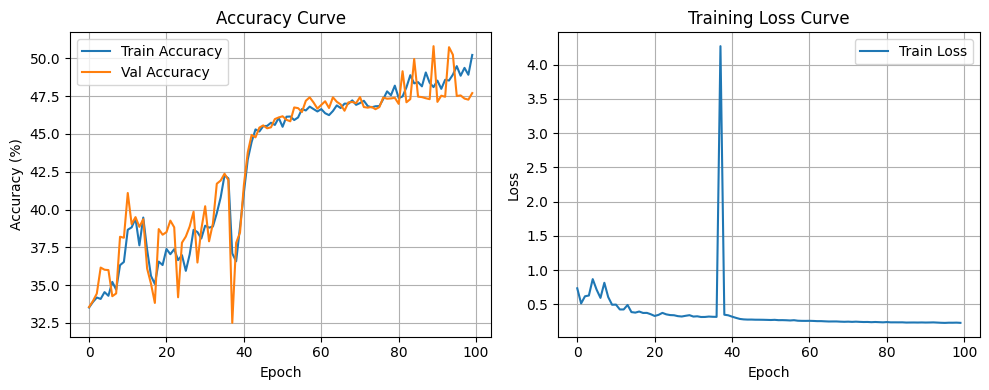

In [7]:
import matplotlib.pyplot as plt

epochs = list(range(n_epochs))

# Accuracy Curve
plt.figure(figsize=(10, 4))
plt.subplot(1, 2, 1)
plt.plot(epochs, train_acc_list, label='Train Accuracy')
plt.plot(epochs, val_acc_list, label='Val Accuracy')
plt.xlabel("Epoch")
plt.ylabel("Accuracy (%)")
plt.title("Accuracy Curve")
plt.legend()
plt.grid(True)

# Loss Curve
plt.subplot(1, 2, 2)
plt.plot(epochs, train_loss_list, label='Train Loss')
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Training Loss Curve")
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()
